In [15]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch.nn.functional as nnF
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from rich.console import Group
from rich.live import Live
from rich.panel import Panel
from rich.progress import Progress, track
from rich.rule import Rule
from rich.style import Style
from rich.text import Text
from torch.utils.data import DataLoader, Dataset

In [2]:
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, patch_size=48, sigma=25, augment=True):
        self.files = sorted(Path(root_dir).glob("*.png"))
        self.patch_size = patch_size
        self.sigma = sigma
        self.augment = augment
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load and transform image
        img = Image.open(self.files[idx]).convert("RGB")
        clean = self.to_tensor(img)

        # Randomly crop the image
        if self.patch_size:
            i = random.randint(0, clean.shape[1] - self.patch_size)
            j = random.randint(0, clean.shape[2] - self.patch_size)
            clean = clean[:, i : i + self.patch_size, j : j + self.patch_size]

        # Add gaussian noise on the fly
        # noisy = clean
        noise = torch.randn_like(clean) * (self.sigma / 255.0)
        noisy = (clean + noise).clamp(0.0, 1.0)

        return noisy, clean

dataset = DenoisingDataset("./data/denoising-datasets/BSD400")

[[Text(-10.0, 0, ''),
  Text(0.0, 0, ''),
  Text(10.0, 0, ''),
  Text(20.0, 0, ''),
  Text(30.0, 0, ''),
  Text(40.0, 0, ''),
  Text(50.0, 0, '')],
 [Text(0, -10.0, ''),
  Text(0, 0.0, ''),
  Text(0, 10.0, ''),
  Text(0, 20.0, ''),
  Text(0, 30.0, ''),
  Text(0, 40.0, ''),
  Text(0, 50.0, '')],
 [],
 []]

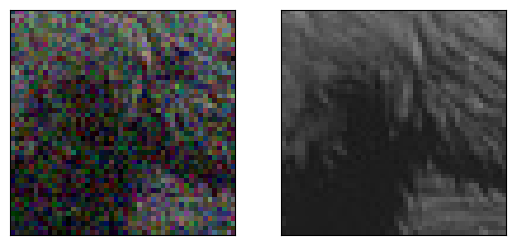

In [3]:
# n, c, name = dataset[0]
n, c = dataset[0]

n = F.to_pil_image(n)
c = F.to_pil_image(c)

fig, axs = plt.subplots(ncols=2)

axs[0].imshow(n)
axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

axs[1].imshow(c)
axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

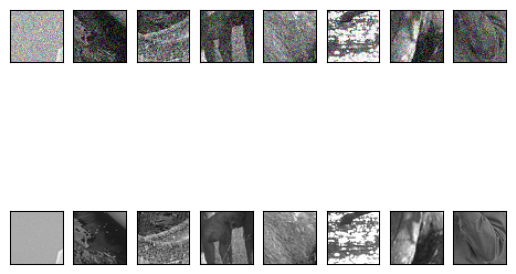

In [4]:
dl = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    # pin_memory=True if torch.cuda.is_available() else False,
)

n, c = next(iter(dl))

fig, axs = plt.subplots(ncols=len(n), nrows=2)

for i, img in enumerate(n):
    img = img.detach()
    img = F.to_pil_image(img)
    axs[0, i].imshow(img)
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for i, img in enumerate(c):
    img = img.detach()
    img = F.to_pil_image(img)
    axs[1, i].imshow(img)
    axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
def activation_function(act, *args, **kwargs):
    act = act.lower()
    if act == "relu":
        return nn.ReLU()
    elif act == "relu6":
        return nn.ReLU6()
    elif act == "leakyrelu":
        return nn.LeakyReLU(0.1)
    elif act == "prelu":
        return nn.PReLU()
    elif act == "rrelu":
        return nn.RReLU(0.1, 0.3)
    elif act == "selu":
        return nn.SELU()
    elif act == "celu":
        return nn.CELU()
    elif act == "elu":
        return nn.ELU()
    elif act == "gelu":
        return nn.GELU()
    elif act == "tanh":
        return nn.Tanh()
    else:
        raise NotImplementedError


def Conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=True
    )


def Conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True
    )


class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, activation="relu"):
        super(DenseLayer, self).__init__()
        self.conv = Conv3x3(in_channels, growth_rate)
        self.act = activation_function(activation)

    def forward(self, x):
        out = self.act(self.conv(x))
        out = torch.cat((x, out), 1)
        return out


class RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layer, activation="relu"):
        super(RDB, self).__init__()
        prev_out_channels = in_channels
        modules = []
        for i in range(num_layer):
            modules.append(DenseLayer(prev_out_channels, growth_rate, activation))
            prev_out_channels += growth_rate
        self.dense_layers = nn.Sequential(*modules)
        self.conv1x1 = Conv1x1(prev_out_channels, in_channels)

    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv1x1(out)
        out += x
        return out


class RDNet(nn.Module):
    def __init__(
        self, in_channels, growth_rate, num_layers, num_blocks, activation="relu"
    ):
        super(RDNet, self).__init__()
        self.num_blocks = num_blocks
        self.RDBs = nn.ModuleList()
        for i in range(num_blocks):
            self.RDBs.append(RDB(in_channels, growth_rate, num_layers, activation))
        self.conv1x1 = Conv1x1(num_blocks * in_channels, in_channels)
        self.conv3x3 = Conv3x3(in_channels, in_channels)

    def forward(self, x):
        out = []
        h = x
        for i in range(self.num_blocks):
            h = self.RDBs[i](h)
            out.append(h)
        out = torch.cat(out, dim=1)
        out = self.conv1x1(out)
        out = self.conv3x3(out)
        return out


class DenoisingModel(nn.Module):
    def __init__(self, in_channels=3, growth_rate=32, num_layer=6, num_blocks=4):
        super(DenoisingModel, self).__init__()
        self.shallow = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.rdnet = RDNet(in_channels, growth_rate, num_layer, num_blocks)
        self.recon = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shallow = self.shallow(x)
        deep = self.rdnet(shallow)
        out = self.recon(deep)
        return x - out  # residual learning: predict noise and subtract


class DenoisingModel(nn.Module):

    def __init__(self, in_channels=3, growth_rate=32, num_layers=6, num_blocks=4):
        super().__init__()
        self.shallow = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.rdnet = RDNet(in_channels, growth_rate, num_layers, num_blocks)
        self.reconstruct = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):

        # Map input to feature space
        d = self.shallow(x)
        
        # Process output through RDNet
        d = self.rdnet(d)

        # Map output back to
        d = self.reconstruct(d)
        
        # Return the residual
        return x - d

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Output()

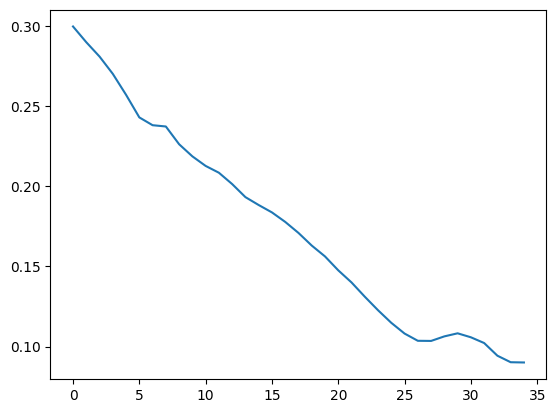

In [ ]:
dl = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True if torch.cuda.is_available() else False,
)

model = DenoisingModel(in_channels=3).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []

epochs = 5

with Progress() as progress:

    epoch_task = progress.add_task("Epochs", total=epochs)
    batch_task = progress.add_task("Batch", total=len(dl))

    for j in range(0, epochs):

        progress.reset(batch_task)

        for i, (noisy, clean) in enumerate(dl):

            noisy = noisy.to(device)
            clean = clean.to(device)

            optimizer.zero_grad()

            output = model(noisy)  # noisy: [B, 3, H, W]

            loss = criterion(output, clean)
            loss.backward()
            optimizer.step()

            progress.update(batch_task, advance=1)

            loss_val = loss.item()
            losses.append(loss_val)
            
        progress.update(epoch_task, advance=1)

plt.plot(losses)

In [6]:
class InferenceDataset(Dataset):
    def __init__(self, root_dir):
        self.originals = sorted((Path(root_dir) / "original").glob("*.png"))
        self.noise15 = sorted((Path(root_dir) / "noise15").glob("*.png"))
        self.noise25 = sorted((Path(root_dir) / "noise25").glob("*.png"))
        self.noise50 = sorted((Path(root_dir) / "noise50").glob("*.png"))

        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.originals)

    def __getitem__(self, idx):
        # Load and transform image
        orig = self.to_tensor(Image.open(self.originals[idx]).convert("RGB"))
        n15 = self.to_tensor(Image.open(self.noise15[idx]).convert("RGB"))
        n25 = self.to_tensor(Image.open(self.noise25[idx]).convert("RGB"))
        n50 = self.to_tensor(Image.open(self.noise50[idx]).convert("RGB"))

        return orig, n15, n25, n50

inference_dataset = InferenceDataset("./data/denoising-datasets/BSD68")

In [9]:
print(inference_dataset[0][0].shape)
print(torch.max(inference_dataset[0][0]))
print(torch.min(inference_dataset[0][0]))

torch.Size([3, 480, 320])
tensor(1.)
tensor(0.0039)


In [23]:
def calc_psnr(noisy: torch.Tensor, original: torch.Tensor):
    mse = nnF.mse_loss(noisy, original)
    return 10 * torch.log10(1.0 / mse)

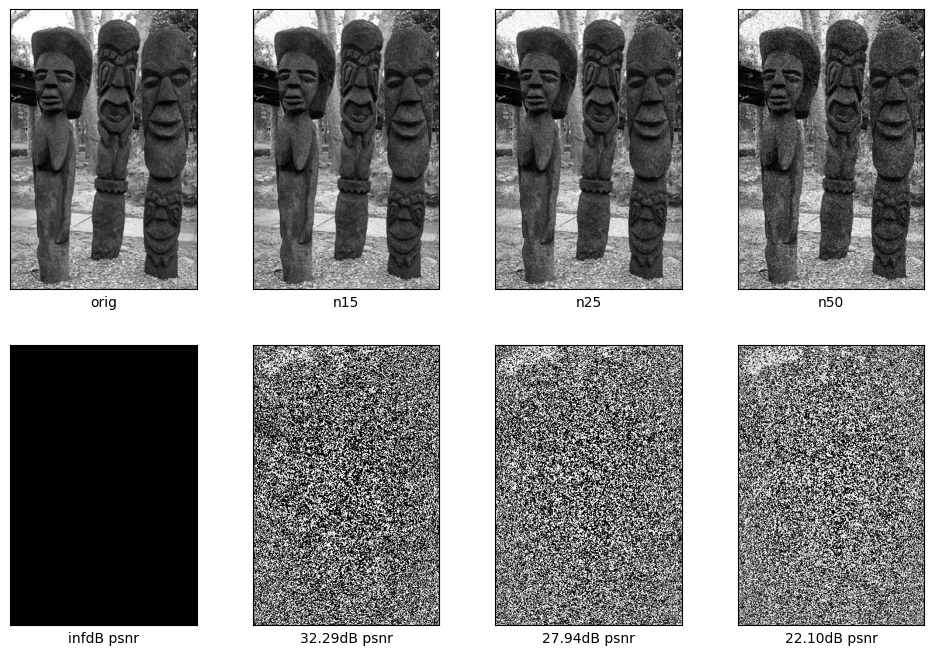

In [24]:
samples = inference_dataset[0]

fig, axs = plt.subplots(ncols=len(samples), nrows=2, figsize=(12, 8))

orig = samples[0]

for i, img in enumerate(samples):
    axs[0, i].imshow(F.to_pil_image(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, i].set_xlabel(["orig", "n15", "n25", "n50"][i])

    axs[1, i].imshow(F.to_pil_image(img - orig))
    axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[1, i].set_xlabel(f"{calc_psnr(img, orig):.2f}dB psnr")



In [ ]:
dl2 = DataLoader(
    inference_dataset,
    batch_size=8,
    shuffle=True,
    # pin_memory=True if torch.cuda.is_available() else False,
)

# n, c = next(iter(dl2))

# fig, axs = plt.subplots(ncols=len(n), nrows=2)

# for i, img in enumerate(n):
#     img = img.detach()
#     img = F.to_pil_image(img)
#     axs[0, i].imshow(img)
#     axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# for i, img in enumerate(c):
#     img = img.detach()
#     img = F.to_pil_image(img)
#     axs[1, i].imshow(img)
#     axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Inference test

# Set the model to evaluation mode
# Equivalent to model.train(False)
model.eval()

# Disable gradient calcultions
# We do this because we don't call model.backwards()
with torch.no_grad():
    noisy = noisy_sample.to(device)
    output = model(noisy)